In [4]:
import numpy as np
import scipy.optimize
import scipy
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

In [5]:
def calc_mu(X):
    T = X.shape[0]
    N = X.shape[1]
    res = np.zeros(N)
    for t in range(T):
        res += X[t]
    return res / T

def calc_sigma(X):
    T = X.shape[0]
    N = X.shape[1]
    mu = calc_mu(X)
    res = np.zeros((N, N))
    for t in range(T):
        res += np.outer(X[t] - mu, (X[t] - mu).T)
    return res / T

def calc_alternative_answer(X):
    T = X.shape[0]
    return 2 / (T - 1) * np.sum(X[:-1], axis=0) - X[-1]

def f(x, base, Sigma):
    X = np.vstack((base, x))
    Sigma_ = calc_sigma(X)
    return np.linalg.norm(Sigma - Sigma_, ord=2)

def project_to_psd_cone(A):
  eigvals, eigvecs = np.linalg.eigh(A)
  eigvals[eigvals < 0] = 0
  A_psd = np.dot(eigvecs, np.dot(np.diag(eigvals), eigvecs.T))
  return A_psd

def get_two_answers(T, X_, SigmaT1):
    N = X_.shape[1]
    SigmaT1 = project_to_psd_cone(SigmaT1)
    SigmaT = calc_sigma(X_)
    muT = calc_mu(X_)
    A = (SigmaT1 - T/(T+1) * SigmaT) * (T+1)**2/T
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    return (-np.sqrt(S[0]) * U.T[0].reshape(N, 1) + muT.reshape(N, 1)).T, (np.sqrt(S[0]) * U.T[0].reshape(N, 1) + muT.reshape(N, 1)).T

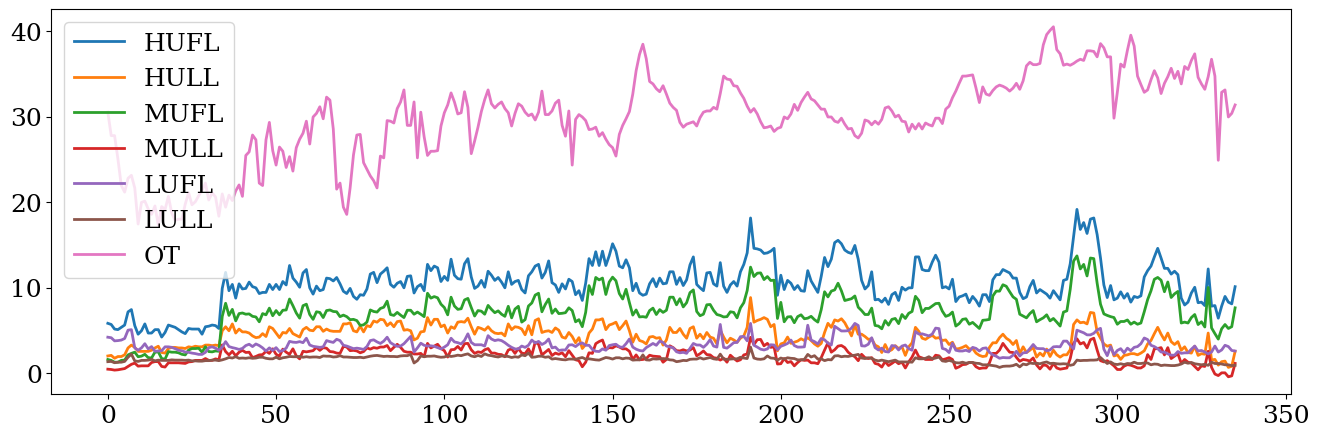

In [6]:
df = pd.read_csv('./ETTh1.csv')
df = df[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']]

HUFL = df['HUFL']
HULL = df['HULL']
MUFL = df['MUFL']
MULL = df['MULL']
LUFL = df['LUFL']
LULL = df['LULL']
OT = df['OT']
TIME = 24 * 7 * 2
plt.figure(figsize=(16, 5))
plt.plot(HUFL[:TIME], label='HUFL')
plt.plot(HULL[:TIME], label='HULL')
plt.plot(MUFL[:TIME], label='MUFL')
plt.plot(MULL[:TIME], label='MULL')
plt.plot(LUFL[:TIME], label='LUFL')
plt.plot(LULL[:TIME], label='LULL')
plt.plot(OT[:TIME], label='OT')
plt.legend()
plt.show()

Names = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

X = np.array([HUFL, HULL, MUFL, MULL, LUFL, LULL, OT]).T
T = X.shape[0]
N = X.shape[1]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


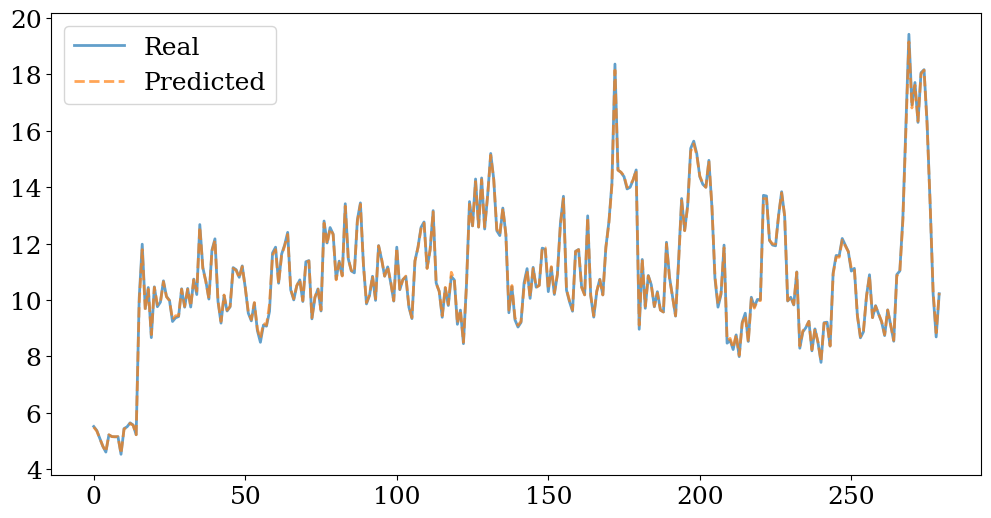

MAE: 0.030638722063171572
MSE: 0.002439030610098284


In [22]:
predicted = []
real = []
T = [10, 20]
maxT = max(T)

for i in range(maxT, 300):
    X_ = X[i-maxT:i]

    Sigma = [calc_sigma(X_[-Ti:]) for Ti in T]
    for i in range(len(Sigma)):
        Sigma[i] += np.random.normal(0, 0, Sigma[i].shape)
    y_hats = [get_two_answers(Ti, X_[-Ti:-1], Sigma[j]) for j, Ti in enumerate(T)]

    min_diameter = 1e9
    best_mask = None
    for mask in range(1 << len(T)):
        anses = [ y_hats[i][mask >> i & 1][0] for i in range(len(T)) ]
        diameter = 0
        for i in range(len(T)):
            for j in range(i+1, len(T)):
                diameter = max(diameter, np.linalg.norm(anses[i] - anses[j]))
        if diameter < min_diameter:
            min_diameter = diameter
            best_mask = mask
    

    mean = np.zeros(N)
    for i in range(len(T)):
        mean += y_hats[i][best_mask >> i & 1][0] / len(T)
    predicted.append(mean)
    real.append(X_[-1])

predicted = np.array(predicted)
real = np.array(real)
plt.figure(figsize=(12, 6))
plt.plot(predicted[:,0], label='predicted', alpha=0.7)
plt.plot(real[:,0], label='real', linestyle='dashed', alpha=0.7)
Names_pred = [f'{name}_predicted' for name in Names]
plt.legend(["Real", "Predicted"])
# plt.title('Predicted time series')
plt.savefig('../paper/figures/' + "IdealRecovery" + '.eps', format='eps')
plt.show()
MAE = np.mean(np.abs(predicted - real))
print('MAE:', MAE)
MSE = np.mean((predicted - real)**2)
print('MSE:', MSE)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


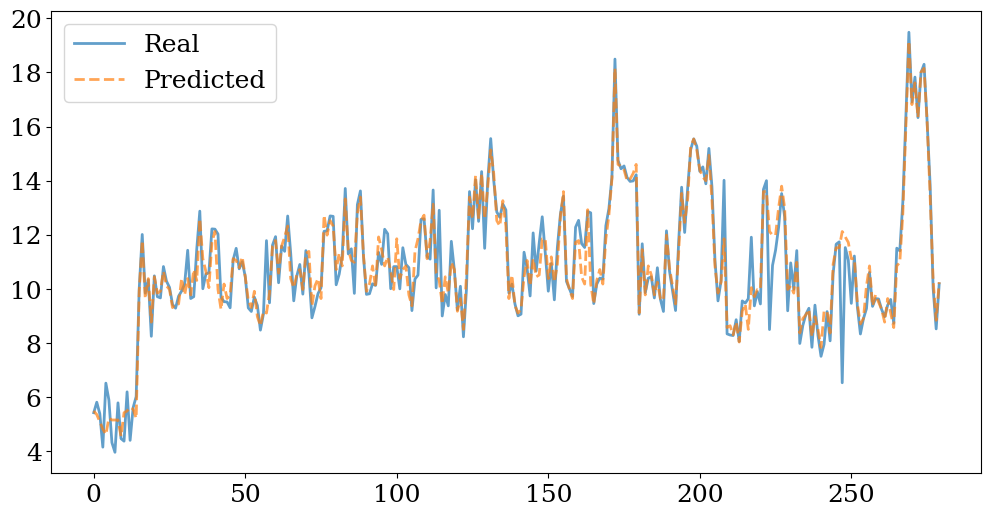

MAE: 0.41093198136406667
MSE: 0.45380256476783287


In [23]:
predicted = []
real = []
T = [10, 20]
maxT = max(T)

for i in range(maxT, 300):
    X_ = X[i-maxT:i]

    Sigma = [calc_sigma(X_[-Ti:]) for Ti in T]
    for i in range(len(Sigma)):
        Sigma[i] += np.random.normal(0, 0.1, Sigma[i].shape)
    y_hats = [get_two_answers(Ti, X_[-Ti:-1], Sigma[j]) for j, Ti in enumerate(T)]

    min_diameter = 1e9
    best_mask = None
    for mask in range(1 << len(T)):
        anses = [ y_hats[i][mask >> i & 1][0] for i in range(len(T)) ]
        diameter = 0
        for i in range(len(T)):
            for j in range(i+1, len(T)):
                diameter = max(diameter, np.linalg.norm(anses[i] - anses[j]))
        if diameter < min_diameter:
            min_diameter = diameter
            best_mask = mask
    

    mean = np.zeros(N)
    for i in range(len(T)):
        mean += y_hats[i][best_mask >> i & 1][0] / len(T)
    predicted.append(mean)
    real.append(X_[-1])

predicted = np.array(predicted)
real = np.array(real)
plt.figure(figsize=(12, 6))
plt.plot(predicted[:,0], label='predicted', alpha=0.7)
plt.plot(real[:,0], label='real', linestyle='dashed', alpha=0.7)
Names_pred = [f'{name}_predicted' for name in Names]
plt.legend(["Real", "Predicted"])
# plt.title('Predicted time series')
plt.savefig('../paper/figures/' + "NonIdealRecovery" + '.eps', format='eps')
plt.show()
MAE = np.mean(np.abs(predicted - real))
print('MAE:', MAE)
MSE = np.mean((predicted - real)**2)
print('MSE:', MSE)

In [24]:
def example_recovery(x, y):
    return ( ((1-x)**2 / 4 - 1)**2 + 2 * ( (1-x)*(2-y)/4 -1)**2 + ((2-y)**2 / 4 - 1)**2 )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


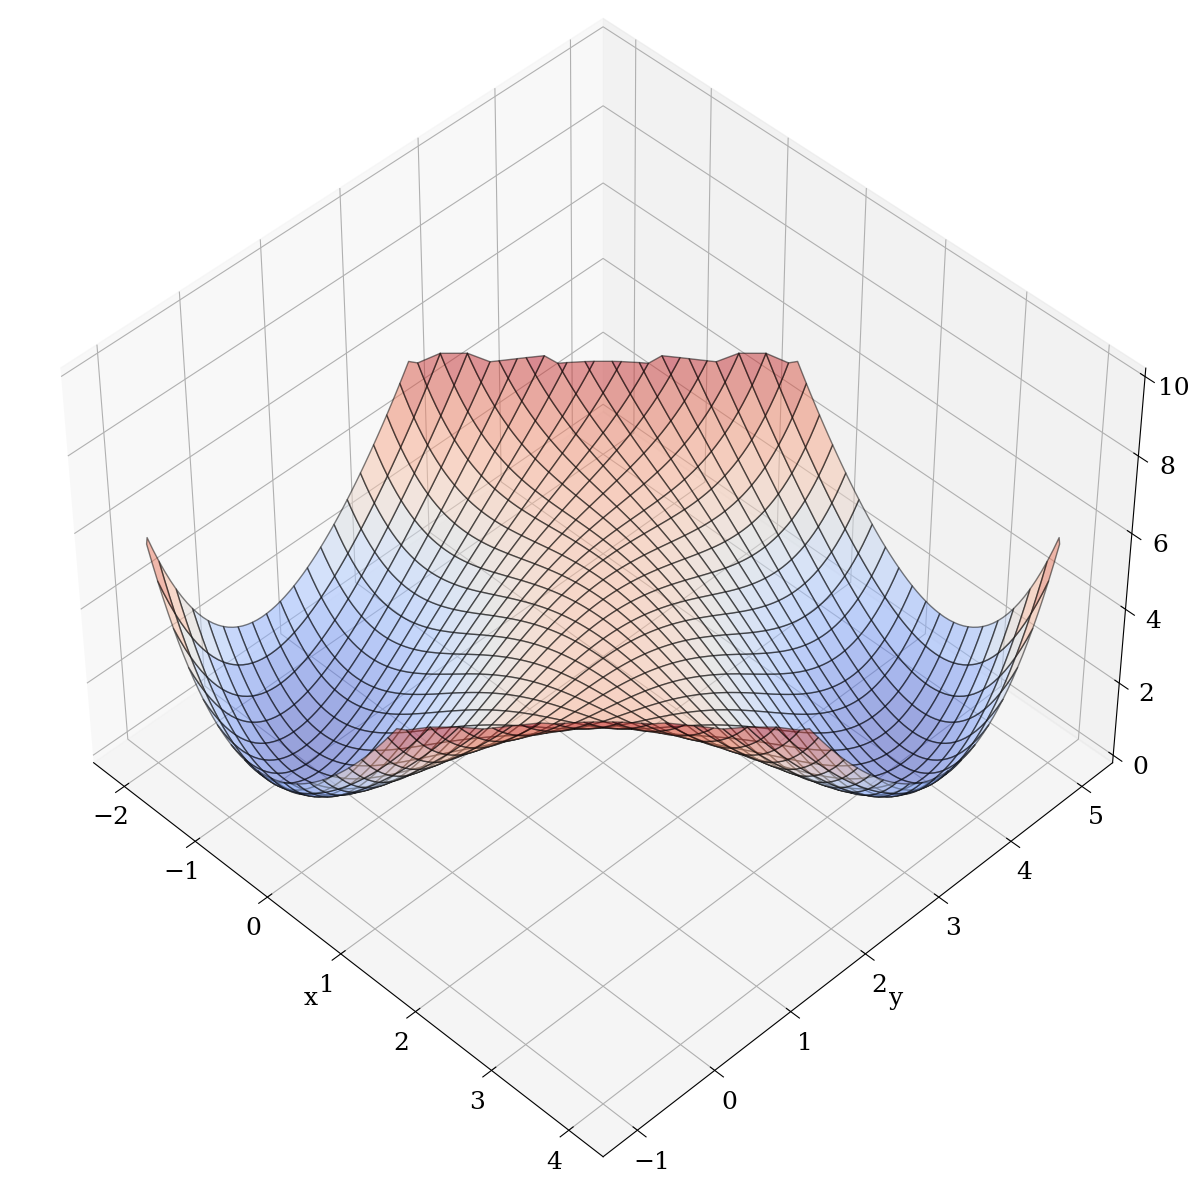

In [130]:
# 3d plot of the function with
x = np.linspace(-2, 4, 100)
y = np.linspace(-1, 5, 100)
X, Y = np.meshgrid(x, y)
Z = example_recovery(X, Y)
Z[Z > 6] = np.nan
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
elev = 45
azim = 180+135
ax.view_init(elev=elev, azim=azim)
ax.plot_surface(X, Y, Z, cmap='coolwarm', rstride=3, cstride=3, alpha=0.5, edgecolor='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlim(0, 10)
plt.savefig('../paper/figures/' + "NonConvex" + '.eps', format='eps')
plt.show()